In [0]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import moments_hu, moments, moments_central, moments_normalized
from sklearn.feature_extraction import image
from sklearn import svm
from skimage.filters import threshold_otsu
from skimage import transform
from skimage.util.shape import view_as_windows
from skimage.morphology import dilation, erosion, opening, closing, square
from scipy.ndimage import morphology
plt.rcParams['figure.figsize'] = [17, 7]
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# helper functions
import os
import skimage.io
import xml.etree.ElementTree as ET
import pickle

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [0]:
root = "/content/drive/My Drive/Colab Notebooks"

data_base_path = os.path.join(root, 'project-data')
images_folder = 'images/'
annotations_folder = 'annotations/'

train_folder = 'train/'
test_folder = 'test/'
validation_folder = 'validation/'


image_train_path = os.path.join(data_base_path, images_folder+train_folder)
image_test_path = os.path.join(data_base_path, images_folder+test_folder)
image_validation_path = os.path.join(data_base_path, images_folder+validation_folder)

annotation_train_path = os.path.join(data_base_path, annotations_folder+train_folder)
annotation_test_path = os.path.join(data_base_path, annotations_folder+test_folder)
annotation_validation_path = os.path.join(data_base_path, annotations_folder+validation_folder)


with open(data_base_path+'/train.txt') as f:
    names_train = [i.strip('\n') for i in f.readlines()]
    
with open(data_base_path+'/test.txt') as f:
    names_test = [i.strip('\n') for i in f.readlines()]

with open(data_base_path+'/validation.txt') as f:
    names_validation = [i.strip('\n') for i in f.readlines()]

image_train_filenames = [os.path.join(image_train_path, name) + '.jpg' for name in names_train]
image_test_filenames = [os.path.join(image_test_path, name) + '.jpg' for name in names_test]
image_validation_filenames = [os.path.join(image_validation_path, name) + '.jpg' for name in names_validation]

# load annotations and images
annotations_train = pickle.load(open(root + '/annotations_train.p', 'rb'))
annotations_test = pickle.load(open(root + '/annotations_test.p', 'rb'))
annotations_validation = pickle.load(open(root + '/annotations_validation.p', 'rb'))

image_train = pickle.load(open(root + '/image_train.p', 'rb'))
image_test = pickle.load(open(root + '/image_test.p', 'rb'))
image_validation = pickle.load(open(root + '/image_validation.p', 'rb'))

## Preprocessing

In [0]:
def varroa_thresholding(input_image):
    
    # Transforming the image to HSV format to find the mean of lightness of image
    image_hsv = cv2.cvtColor(input_image,cv2.COLOR_RGB2HSV)
    mean_hsv = np.mean(image_hsv[:,:,2])
    
    # Improving the lightness based on the mean lightness of the image (if it is not decent)
    if (mean_hsv <= 110):
        image_hsv[:,:,2] = image_hsv[:,:,2] *1.2
    elif(mean_hsv > 150):
        image_hsv[:,:,2] = image_hsv[:,:,2] *0.8
    
    # Performing an adaptive thresholding on the grayscale version of image
    image_rgb = cv2.cvtColor(image_hsv,cv2.COLOR_HSV2RGB)
    image_grayscale = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2GRAY)
    image_thresholded= ~(cv2.adaptiveThreshold(image_grayscale,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,3))
    
    # Performing different morphological operations to improve the result
    image_processed = skimage.morphology.remove_small_objects(image_thresholded.astype(bool), min_size=300)
    image_processed = skimage.morphology.binary_opening(image_processed.astype(bool), selem = square(4), out=None)
    image_processed = skimage.morphology.binary_closing(image_processed.astype(bool), selem = square(5), out=None)
    image_processed = skimage.morphology.binary_erosion(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.binary_dilation(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.remove_small_objects(image_processed.astype(bool), min_size=230)
    image_processed = skimage.morphology.binary_opening(image_processed, selem = square(6), out=None)
    image_processed = morphology.binary_fill_holes(image_processed).astype(np.uint8)
    
    return image_processed

In [0]:
# generate the test data
image_test_preprocess = [varroa_thresholding(img) for img in image_test]
image_valid_preprocess = [varroa_thresholding(img) for img in image_validation]

In [0]:
# load the train data
with open(root + '/hardnegfromval.p', 'rb') as f:
  hardnegs = pickle.load(f)

with open(root + '/negSamples.p', 'rb') as f:
  negSamples = pickle.load(f)
  
with open(root + '/posSamples.p', 'rb') as f:
  posSamples = pickle.load(f)

In [8]:
import keras
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [9]:
len(negSamples)

166604

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(40, 40, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model
img_input = Input(shape=(40,40,3))

x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv1')(img_input)
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv1')(x)
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv1')(x)
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv2')(x)
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv1')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv2')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv1')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv2')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096, activation='relu', name='fc1')(x)
x = layers.Dense(4096, activation='relu', name='fc2')(x)
x = layers.Dense(2, activation='softmax', name='predictions')(x)

model2 = Model(inputs=img_input, outputs=x)
model2.compile(optimizer='sgd',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

In [0]:
def normalizeImage(img):
  img_new = np.zeros_like(img)
#   img_new = img / 255
  
  
  
#   img_new[:,:,0] = (img[:,:,0]-np.min(img[:,:,0])) / (np.max(img[:,:,0]) - np.min(img[:,:,0]))
#   img_new[:,:,1] = (img[:,:,1]-np.min(img[:,:,1])) / (np.max(img[:,:,1]) - np.min(img[:,:,1]))
#   img_new[:,:,2] = (img[:,:,2]-np.min(img[:,:,2])) / (np.max(img[:,:,2]) - np.min(img[:,:,1]))
  img_new[:,:,0] = (img[:,:,0]-np.mean(img[:,:,0])) / np.std(img[:,:,0])
  img_new[:,:,1] = (img[:,:,1]-np.mean(img[:,:,1])) / np.std(img[:,:,1])
  img_new[:,:,2] = (img[:,:,2]-np.mean(img[:,:,2])) / np.std(img[:,:,2])
  
  return img_new

In [0]:
negInd = np.random.choice(len(negSamples), len(posSamples))
negSelect = [negSamples[ind] for ind in negInd] + hardnegs

X_train = posSamples + negSelect
X_train = np.array([normalizeImage(img) for img in X_train])
y_train = [1 for _ in range(len(posSamples))] + [0 for _ in range(len(negSelect))]
y_train = keras.utils.to_categorical(y_train)

del(negSamples)
del(posSamples)
del(negSelect)
del(hardnegs)

In [17]:
np.shape(X_train)

(93425, 40, 40, 3)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_std_normalization=True,
    rotation_range=20,
    horizontal_flip=True)
datagen.fit(X_train)

In [27]:
epochs = 20
# model2.fit_generator(datagen.flow(np.array(X_train), y_train, batch_size=512), steps_per_epoch=len(X_train) / 512, epochs=epochs)
model2.fit(x=X_train, y=y_train, validation_split=0.2, epochs=50, batch_size=256)

Train on 74740 samples, validate on 18685 samples
Epoch 1/50
74740/74740 [==============================] - 113s 2ms/step - loss: 0.5173 - acc: 0.7375 - val_loss: 1.0466 - val_acc: 0.4854
Epoch 2/50
74740/74740 [==============================] - 109s 1ms/step - loss: 0.4097 - acc: 0.8229 - val_loss: 1.1727 - val_acc: 0.4756
Epoch 3/50
74740/74740 [==============================] - 110s 1ms/step - loss: 0.3890 - acc: 0.8335 - val_loss: 0.9896 - val_acc: 0.5459
Epoch 4/50
74740/74740 [==============================] - 110s 1ms/step - loss: 0.3780 - acc: 0.8391 - val_loss: 1.0427 - val_acc: 0.4977
Epoch 5/50
74740/74740 [==============================] - 110s 1ms/step - loss: 0.3735 - acc: 0.8397 - val_loss: 0.8172 - val_acc: 0.5898
Epoch 6/50
74740/74740 [==============================] - 110s 1ms/step - loss: 0.3667 - acc: 0.8452 - val_loss: 0.8314 - val_acc: 0.5730
Epoch 7/50
74740/74740 [==============================] - 109s 1ms/step - loss: 0.3613 - acc: 0.8471 - val_loss: 0.7636 - 

In [0]:
model2.save(root + '/cnn_5_28_v1.h5')

In [0]:
from keras.models import load_model
model2 = load_model(root + '/weights-0.91-v1.hdf5')

In [0]:
pred_prob = model2.predict(X_train)
pred =np.argmax(pred_prob, axis=1)
np.sum(pred)


56433

In [0]:
y_label = np.argmax(y_train, axis=1)

In [0]:
np.mean(pred==y_label)

0.8251645705111051

In [0]:
np.argmax(np.array([[0.04076334, 0.9592367 ], [0.07372799, 0.926272  ]]), axis=1)

array([1, 1])

In [0]:
def IoUperBlock(img, blocks, gtblock, verbose=0):
    """
        Input:
            img: np.darray
            blocks: list of the prediction ground
            gtblock: groundTruth
        return: IoU value
    """
    
    width, height = np.shape(img)

    res = []
    resBlock = []
    for block in blocks:
        imgOri = np.zeros_like(img)
        imggt = np.zeros_like(imgOri)
        
        minr = block[0]
        minc = block[1]
        maxr = min(block[0]+block[2], width)
        maxc = min(block[1]+block[3], height)
        
        imgOri[minr:maxr, minc:maxc] = 1

        imggt[gtblock['bbox'][1]:gtblock['bbox'][1] + gtblock['bbox'][3], gtblock['bbox'][0]:gtblock['bbox'][0] + gtblock['bbox'][2]] = 1

        imgol = imggt + imgOri

        sizeI = np.sum(imgol == 2)
        sizeU = np.sum(imgol == 1) + np.sum(imgol == 2)
        if sizeI > 0:
            if verbose:
                print('IoU is %f' % (sizeI / sizeU))
                plt.imshow(imgol)
                plt.show()
            res.append(sizeI/sizeU)
            resBlock.append(block)
    
    if res:
        return resBlock[np.argmax(res)], np.max(res)
    
    return None, 0.0

In [0]:
def centerornot(patch):
    a = cv2.moments(patch)
    
    xg = a['m01'] // a['m00']
    yg = a['m10'] // a['m00']
    
    h,w = np.shape(patch)
    
    return np.abs(h//2 - xg) + np.abs(w//2 - yg)

def getGcenter(patch):
    a = cv2.moments(patch)
    xg = a['m01'] // a['m00']
    yg = a['m10'] // a['m00']
    
    return (xg, yg)

def combineWindows(img_pos,img):
    img_record = img.copy()
    
    block_area = []

    for block in img_pos:
        x = block[0]
        y = block[1]
        h = block[2]
        w = block[3]
        try:
          (xg, yg) = getGcenter(img[x:x+h, y:y+w])
        except:
          continue
          
        if np.sum(img[x:x+h, y:y+w]) < h * w // 10:
          continue
        
        if len(block_area) == 0:
            block_area.append([[block],(x+xg, y+yg)])
            continue
        flag = 1
        for block_record in block_area:
            if np.abs(x+xg - block_record[1][0]) + np.abs(y+yg-block_record[1][1]) < 40:
                block_record[0].append(block)
                x_ = []
                y_ = []
                for b in block_record[0]:
                    c_ = getGcenter(img[b[0]:b[0]+b[2], b[1]:b[1]+b[3]])
                    x_.append(b[0]+c_[0])
                    y_.append(b[1]+c_[1])
                block_record[1] = (np.mean(x_), np.mean(y_))
                flag = 0
        if flag:
            block_area.append([[block],(x+xg, y+yg)])
        
    res = []
    for block_record in block_area:
        temp = block_record[0]
        temp_sort = sorted(temp, key=lambda x: centerornot(img[x[0]:x[0]+x[2], x[1]:x[1]+x[3]]))
        res.append(temp_sort[0])
    
    return res

In [0]:
def blockIOU(img, blk1, blk2):
  H, W = np.shape(img)[:2]
  img_record = np.zeros((H,W))
  
  xMin1 = blk1[0]
  yMin1 = blk1[1]
  xMax1 = xMin1 + blk1[1]
  yMax1 = yMin1 + blk1[2]
  
  xMin2 = blk2[0]
  yMin2 = blk2[1]
  xMax2 = xMin2 + blk2[1]
  yMax2 = yMin2 + blk2[2]
  
  img_record[xMin1:xMax1, yMin1:yMax1] += 1
  img_record[xMin2:xMax2, yMin2:yMax2] += 1
  
  I = np.sum(img_record == 2)
  U = np.sum(img_record > 0)
  
  return I / U
  
  
  
def combineWindowsNMS(img, blk_list, conf_list, iou_thresh=0.):
  print(conf_list)
  # combine blk_list and conf_list:
  blk_conf = list(zip(blk_list, conf_list))
  
  blk_conf = sorted(blk_conf, key=lambda x: x[1], reverse=True)
  
  # build up IOU matrix, accept_record, and delete_record
  num_blk = len(blk_conf)
  blk_accept = np.zeros(num_blk)
  blk_delete = np.zeros(num_blk)
  iou_matrix = np.zeros((num_blk, num_blk))
  
  print(1)
  # calculate the iou matrix
  for i_head in range(num_blk):
    iou_matrix[i_head, i_head] = 1.
    for i_follow in range(i_head, num_blk):
      iou_val = blockIOU(img, blk_conf[i_head][0], blk_conf[i_follow][0])
      iou_matrix[i_head, i_follow] = iou_val
      iou_matrix[i_follow, i_head] = iou_val
  
  print(2)
  # result
  for ind in range(num_blk):
    if blk_accept[ind] or blk_delete[ind]:
      continue
    
    blk_accept[ind] = 1
    
    blk_overlap = np.where(iou_matrix[ind,:] > iou_thresh)[0]
    if len(blk_overlap) == 0:
      continue
    
    for idx in range(num_blk):
      if idx in blk_overlap and idx > ind:
        blk_delete[idx] = 1
  print(3)
  blk_res = []
  for ind in range(num_blk):
    if blk_accept[ind] and not blk_delete[ind]:
      blk_res.append(blk_conf[ind][0])
  
  return blk_res

In [0]:
TP = 0
ALL_ANNO = 0
ALL_DET = 0

def detect_by_method_1(img, img_origin, blockSize, stepSize, anno):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    global TP, ALL_ANNO, ALL_DET
    
    Height, Width = np.shape(img)
    img_record = np.zeros_like(img)
    
    img_patches = view_as_windows(arr_in=img, window_shape=(blockSize, blockSize), step=stepSize)
    h_patchs, w_patchs = np.shape(img_patches)[:2]
    img_records = {(i, j):img_patches[i,j] for i in range(np.shape(img_patches)[0]) for j in range(np.shape(img_patches)[1])}
    
#     img_norm = normalizeImage(img_origin)
    img_rgbpatches = [normalizeImage(img_origin[i*stepSize:i*stepSize+blockSize, j*stepSize:j*stepSize+blockSize,:]) for i in range(h_patchs) for j in range(w_patchs)]
    
    pred_prob = model2.predict(np.array(img_rgbpatches))
    
    pred = np.argmax(pred_prob, axis=1)
    
    img_filter = [[(i, j), img_origin[i*stepSize:i*stepSize+blockSize, j*stepSize:j*stepSize+blockSize]] for i in range(h_patchs) for j in range(w_patchs) if pred[i*w_patchs+j]]
    
    prob_list = [pred_prob[ind, 1] for ind in range(len(pred)) if pred[ind]]
    
    img_positions = [[img_block[0][0]*stepSize, img_block[0][1]*stepSize, blockSize, blockSize] for img_block in img_filter]
    print(len(img_positions))
#     img_positions = combineWindows(img_positions, img)
#     print(len(img_positions))
    fig, ax = plt.subplots(1,1)
  
#     if len(img_positions) > 50:
#       blk_conf = list(zip(img_positions, prob_list))
#       blk_conf = sorted(blk_conf, key=lambda x:x[1], reverse=True)[:50]
#       print(blk_conf)
#       img_positions, blk_conf = list(map(list,list(zip(*blk_conf))))
      
#     print('The number before is ', len(img_positions))
#     img_positions = combineWindowsNMS(img, img_positions, prob_list)
#     print('The number after is ', len(img_positions))

    block_record = []
    fp_blocks = []
    for an in anno:
        block, iou_val = IoUperBlock(img, img_positions, an)
        if iou_val >= 0.3:
            rect = patches.Rectangle((block[1], block[0]), block[3], block[2],
                linewidth=0.5,edgecolor='g',facecolor='none')
            ax.add_patch(rect)
            block_record.append(block)
            
    
    for img_block in img_positions:
        if img_block not in block_record:
            rect = patches.Rectangle((img_block[1], img_block[0]), img_block[3], img_block[2],
                    linewidth=0.5,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            fp_blocks.append(img_origin[img_block[0]:img_block[0]+img_block[2], img_block[1]:img_block[1]+img_block[3], :])
    
    for an in anno:
        rect = patches.Rectangle((an['bbox'][0], an['bbox'][1]), an['bbox'][2], an['bbox'][3],
                linewidth=1,edgecolor='black',facecolor='none')
    #         ax[0].add_patch(rect)
        ax.add_patch(rect)
      
    TP += len(block_record)
    ALL_ANNO += len(anno)
    ALL_DET += len(img_positions)
    
    try:
      P = TP/ALL_DET
      R = TP/ALL_ANNO
      F1 = 2*P*R/(P+R)
      print('P: {} R: {} F1: {}'.format(P, R, F1))
    except:
      print('TP: {} ALL_ANNO: {} ALL_DET: {}'.format(TP, ALL_ANNO, ALL_DET))
    precision = 0.0
    recall = 0.0
    F1 = 0.0
    
    if len(img_positions) > 0:
        precision = len(block_record) / len(img_positions)
    
    if len(anno) > 0:
        recall = len(block_record) / len(anno)
    
    if precision + recall > 0:
        F1 = 2 * (precision * recall) / (precision + recall)
    ax.set_title('Precision: %.4f Recall: %.4f, F1-score: %.4f' % (precision, recall, F1))
    ax.imshow(img_origin)
    plt.show()
    

    return fp_blocks

Image  0
[([1000, 160, 40, 40], 0.9999865), ([20, 480, 40, 40], 0.99994946), ([260, 860, 40, 40], 0.99994004), ([1120, 780, 40, 40], 0.9999318), ([240, 200, 40, 40], 0.9999231), ([540, 1120, 40, 40], 0.99991345), ([1280, 580, 40, 40], 0.9998994), ([500, 140, 40, 40], 0.9998791), ([200, 40, 40, 40], 0.99979585), ([1320, 1600, 40, 40], 0.9997912), ([920, 920, 40, 40], 0.99976367), ([1020, 1480, 40, 40], 0.9997205), ([920, 1420, 40, 40], 0.9997067), ([240, 80, 40, 40], 0.99970067), ([1440, 320, 40, 40], 0.9996062), ([440, 1260, 40, 40], 0.99952793), ([1340, 360, 40, 40], 0.9994956), ([1220, 840, 40, 40], 0.9994935), ([1240, 180, 40, 40], 0.9994079), ([280, 1180, 40, 40], 0.9991341), ([1620, 720, 40, 40], 0.99904436), ([1120, 1080, 40, 40], 0.9989397), ([900, 320, 40, 40], 0.9986727), ([660, 1440, 40, 40], 0.998615), ([1400, 800, 40, 40], 0.9984913), ([840, 1500, 40, 40], 0.9983382), ([1240, 1140, 40, 40], 0.9982528), ([1260, 240, 40, 40], 0.9980938), ([1560, 1040, 40, 40], 0.998085), ([11

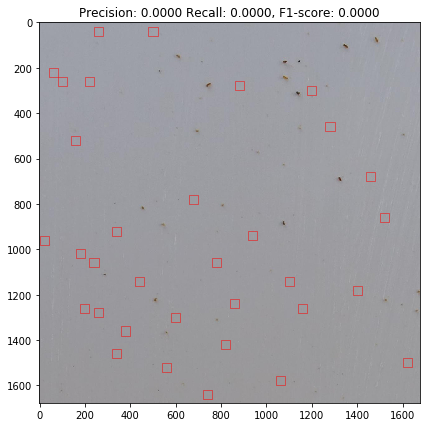

The fp number is 33
Image  1
[([540, 360, 40, 40], 0.9999809), ([360, 400, 40, 40], 0.9999552), ([1360, 1540, 40, 40], 0.9998635), ([880, 1280, 40, 40], 0.99984217), ([1040, 1360, 40, 40], 0.99981815), ([520, 1160, 40, 40], 0.999811), ([500, 1020, 40, 40], 0.99978167), ([520, 1000, 40, 40], 0.9997781), ([720, 1440, 40, 40], 0.999775), ([1200, 1140, 40, 40], 0.99974364), ([1100, 1560, 40, 40], 0.99973506), ([800, 540, 40, 40], 0.9996462), ([560, 1520, 40, 40], 0.99963844), ([1220, 1140, 40, 40], 0.99962676), ([1120, 740, 40, 40], 0.99961346), ([1340, 1300, 40, 40], 0.99948335), ([1120, 1420, 40, 40], 0.9993749), ([1260, 1200, 40, 40], 0.99934524), ([840, 1220, 40, 40], 0.99933726), ([1040, 1340, 40, 40], 0.9993316), ([1280, 880, 40, 40], 0.9992699), ([1320, 460, 40, 40], 0.99915373), ([180, 520, 40, 40], 0.99899167), ([1280, 480, 40, 40], 0.99896705), ([1220, 1420, 40, 40], 0.9989286), ([140, 560, 40, 40], 0.9989208), ([540, 1580, 40, 40], 0.9988839), ([380, 1400, 40, 40], 0.9987205), (

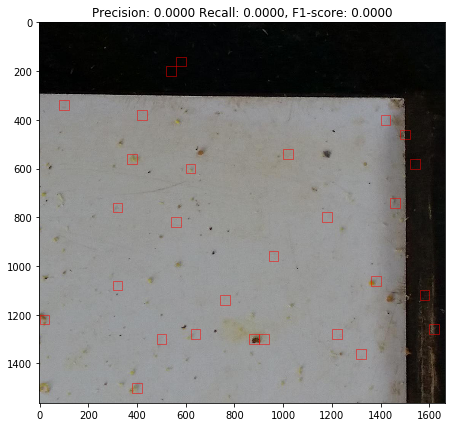

The fp number is 61
Image  2
[([1120, 980, 40, 40], 0.9999732), ([120, 180, 40, 40], 0.9999404), ([200, 640, 40, 40], 0.999926), ([380, 260, 40, 40], 0.9999149), ([940, 220, 40, 40], 0.99988294), ([480, 660, 40, 40], 0.9998826), ([900, 1140, 40, 40], 0.999874), ([300, 1400, 40, 40], 0.99986196), ([1180, 420, 40, 40], 0.99979776), ([540, 600, 40, 40], 0.99979144), ([560, 340, 40, 40], 0.9997882), ([40, 500, 40, 40], 0.9997608), ([160, 1260, 40, 40], 0.99975127), ([440, 0, 40, 40], 0.99973387), ([360, 440, 40, 40], 0.9997274), ([60, 40, 40, 40], 0.9997081), ([240, 1440, 40, 40], 0.9995478), ([1280, 500, 40, 40], 0.99952483), ([600, 380, 40, 40], 0.9994685), ([1320, 1320, 40, 40], 0.9994374), ([720, 1240, 40, 40], 0.9993812), ([960, 300, 40, 40], 0.99937266), ([1160, 500, 40, 40], 0.99936813), ([380, 1020, 40, 40], 0.99926), ([1360, 40, 40, 40], 0.9992513), ([460, 1080, 40, 40], 0.9992422), ([620, 640, 40, 40], 0.9992131), ([1280, 1260, 40, 40], 0.99916744), ([540, 340, 40, 40], 0.9991037

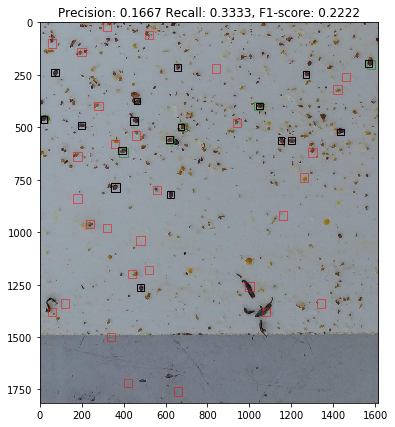

The fp number is 91
Image  3
[([1660, 820, 40, 40], 0.9999405), ([380, 1440, 40, 40], 0.99987006), ([1580, 0, 40, 40], 0.9998424), ([1660, 1220, 40, 40], 0.9998375), ([1580, 840, 40, 40], 0.9997845), ([1660, 720, 40, 40], 0.9995364), ([1580, 200, 40, 40], 0.99933285), ([40, 760, 40, 40], 0.9989716), ([200, 880, 40, 40], 0.99878174), ([120, 140, 40, 40], 0.99830484), ([1420, 1000, 40, 40], 0.9980615), ([1660, 1500, 40, 40], 0.9978369), ([400, 1280, 40, 40], 0.9972038), ([1660, 300, 40, 40], 0.9968573), ([1660, 0, 40, 40], 0.9960012), ([1660, 200, 40, 40], 0.9958619), ([400, 480, 40, 40], 0.99582386), ([1660, 540, 40, 40], 0.99570316), ([120, 100, 40, 40], 0.99415094), ([1560, 880, 40, 40], 0.99324316), ([1600, 0, 40, 40], 0.9928342), ([340, 260, 40, 40], 0.9921476), ([520, 280, 40, 40], 0.9913931), ([1660, 1460, 40, 40], 0.9907114), ([680, 1640, 40, 40], 0.9876016), ([400, 460, 40, 40], 0.9875519), ([1500, 80, 40, 40], 0.98714477), ([1460, 1480, 40, 40], 0.985932), ([1620, 340, 40, 40],

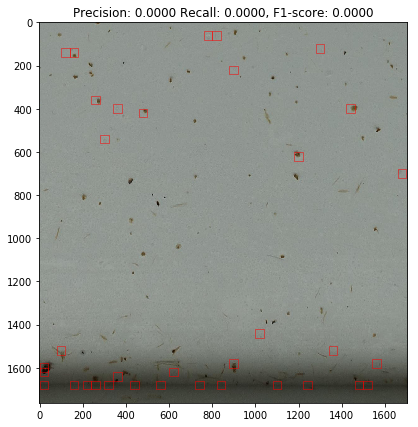

The fp number is 126
Image  4
[([740, 1120, 40, 40], 0.9999682), ([360, 880, 40, 40], 0.99996305), ([700, 1200, 40, 40], 0.99994636), ([780, 1240, 40, 40], 0.99993396), ([120, 240, 40, 40], 0.99993217), ([320, 1640, 40, 40], 0.9999155), ([1200, 920, 40, 40], 0.99989474), ([0, 380, 40, 40], 0.99989164), ([280, 340, 40, 40], 0.9998841), ([640, 240, 40, 40], 0.9998832), ([800, 1520, 40, 40], 0.9998764), ([1400, 940, 40, 40], 0.9998745), ([140, 600, 40, 40], 0.99986744), ([760, 100, 40, 40], 0.9998629), ([360, 540, 40, 40], 0.99983275), ([1400, 1200, 40, 40], 0.99982053), ([240, 20, 40, 40], 0.999816), ([1520, 1440, 40, 40], 0.9998159), ([620, 160, 40, 40], 0.9997905), ([1280, 20, 40, 40], 0.9997739), ([340, 20, 40, 40], 0.9997677), ([700, 1340, 40, 40], 0.99973387), ([840, 1620, 40, 40], 0.9997323), ([500, 1480, 40, 40], 0.9997024), ([260, 1140, 40, 40], 0.99968004), ([1260, 600, 40, 40], 0.9996649), ([700, 780, 40, 40], 0.9995987), ([780, 760, 40, 40], 0.99958557), ([1600, 200, 40, 40], 

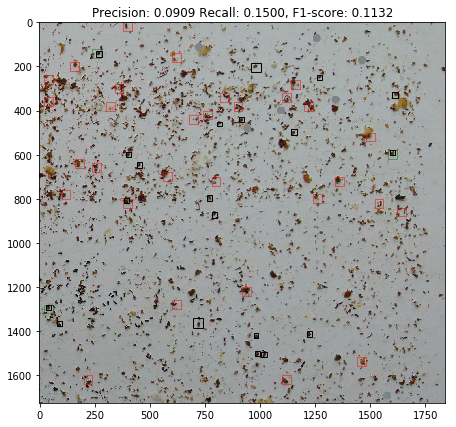

The fp number is 156
Image  5
[([1200, 720, 40, 40], 0.9999889), ([240, 420, 40, 40], 0.99995315), ([1020, 420, 40, 40], 0.9999354), ([480, 300, 40, 40], 0.99992466), ([280, 580, 40, 40], 0.9999075), ([20, 280, 40, 40], 0.99990046), ([900, 1840, 40, 40], 0.99989796), ([560, 840, 40, 40], 0.9998888), ([720, 340, 40, 40], 0.9998847), ([260, 760, 40, 40], 0.999884), ([280, 1120, 40, 40], 0.9998771), ([760, 220, 40, 40], 0.9998698), ([540, 1300, 40, 40], 0.9998634), ([1200, 1400, 40, 40], 0.9998599), ([720, 1240, 40, 40], 0.99985504), ([1260, 1160, 40, 40], 0.99985194), ([280, 540, 40, 40], 0.99983394), ([760, 640, 40, 40], 0.9998148), ([900, 300, 40, 40], 0.99978334), ([900, 340, 40, 40], 0.999739), ([520, 1120, 40, 40], 0.99973387), ([1120, 100, 40, 40], 0.99972993), ([1180, 1360, 40, 40], 0.99971825), ([320, 360, 40, 40], 0.99971575), ([420, 1560, 40, 40], 0.99970263), ([1120, 440, 40, 40], 0.9997003), ([1140, 1820, 40, 40], 0.99968934), ([760, 660, 40, 40], 0.9995552), ([180, 820, 40, 

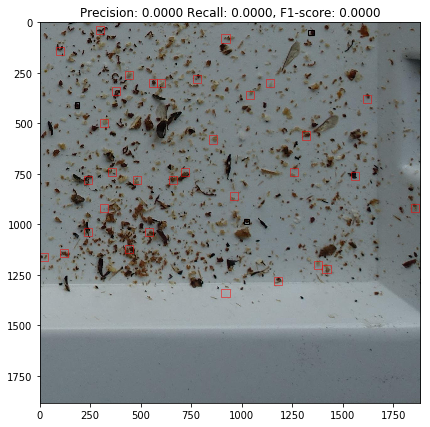

The fp number is 189
Image  6


KeyboardInterrupt: ignored

In [27]:
fp_records = []
for i in range(len(image_valid_preprocess)):
    print('Image ', i)
    tmp = detect_by_method_1(img=image_test_preprocess[i], img_origin=image_test[i], blockSize=40, stepSize=20, anno=annotations_test[i])
    fp_records.extend(tmp)
    print('The fp number is %d' % len(fp_records))

In [0]:
with open(root + '/secondhardneg.p', 'wb') as f:
  pickle.dump(fp_records,f)

2421
P: 0.007434944237918215 R: 0.9 F1: 0.014748054076198279


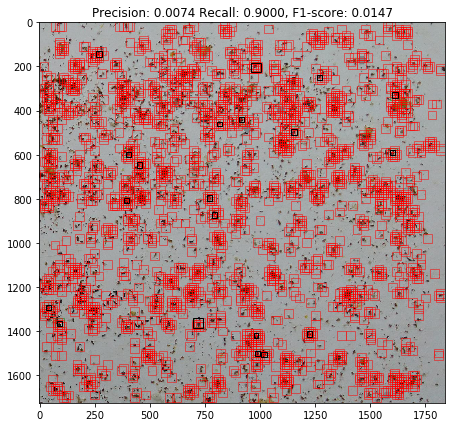

In [39]:
tmp = detect_by_method_1(img=image_test_preprocess[4], img_origin=image_test[4], blockSize=40, stepSize=10, anno=annotations_test[4])

In [33]:
import os
os.listdir(root)

['lab_02_object_description.ipynb',
 'filtered_90k.pickle',
 'filtered_value50.pickle',
 'filtered_value30.pickle',
 'data.pkl',
 'miniproject2_ChatBot.ipynb',
 'project-data',
 'annotations_test.p',
 'annotations_validation.p',
 'image_train.p',
 'image_test.p',
 'image_validation.p',
 'annotations_train.p',
 'negSelect.p',
 'cnn_classifier',
 'cnn_classifier_iou',
 'cnn_classifier_36',
 'cnn_classifier_48',
 'cnn_classifier_24',
 'special_project_Fengyu.ipynb',
 'negSamples.p',
 'posSamples.p',
 'hardnegfromval.p',
 'secondhardneg.p',
 'CNN.ipynb',
 'cnn_5_28_v1.h5',
 'weights-0.91-v1.hdf5']